In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_1.csv")


In [12]:
dataFrame = pd.read_csv(resultsPath)

dataFrame["vectorSize"] = dataFrame["vectorSize"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Vector sizes:", sorted(dataFrame["vectorSize"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 210
Modes: ['min' 'max']
Vector sizes: [1000000, 5000000, 10000000]
Process counts: [1, 2, 4, 6, 8, 16, 32]


,testType,vectorSize,numProcesses,mode,timeSeconds,resultValue,runIndex,mpiEnv
0,MPI_1,1000000,1,min,0.003858,0.444222,4,SLURM_NTASKS=1;JOBID=12433
1,MPI_1,1000000,1,min,0.003685,3.730131,1,SLURM_NTASKS=1;JOBID=12430
2,MPI_1,1000000,1,min,0.004162,0.118172,5,SLURM_NTASKS=1;JOBID=12434
3,MPI_1,1000000,1,min,0.003880,0.100334,2,SLURM_NTASKS=1;JOBID=12431
4,MPI_1,1000000,2,min,0.003188,2.160792,1,SLURM_NTASKS=2;JOBID=12435
5,MPI_1,1000000,2,min,0.003226,0.361948,2,SLURM_NTASKS=2;JOBID=12436
6,MPI_1,1000000,2,min,0.003254,0.011824,3,SLURM_NTASKS=2;JOBID=12437
7,MPI_1,1000000,2,min,0.003184,2.059150,4,SLURM_NTASKS=2;JOBID=12438


In [13]:
groupedFrame = dataFrame.groupby(["mode","vectorSize","numProcesses"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","vectorSize","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)


,mode,vectorSize,numProcesses,median,mean,std,count
0,max,1000000,1,0.004029,0.003967,0.000249,5
1,max,1000000,2,0.003176,0.003186,0.000056,5
2,max,1000000,4,0.006101,0.006198,0.000263,5
3,max,1000000,6,0.009313,0.009346,0.000707,5
4,max,1000000,8,0.007423,0.007485,0.000871,5
5,max,1000000,16,0.012861,0.012948,0.001103,5
6,max,1000000,32,0.117327,0.117434,0.001767,5
7,max,5000000,1,0.020911,0.020909,0.000039,5
8,max,5000000,2,0.016906,0.016908,0.000067,5
9,max,5000000,4,0.017283,0.017304,0.000198,5


In [14]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (modeVal, vectorSizeVal), subFrame in groupedDf.groupby(["mode","vectorSize"]):
        baseRows = subFrame[subFrame["numProcesses"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,mode,vectorSize,numProcesses,median,mean,std,count,speedup,efficiency
0,max,1000000,1,0.004029,0.003967,0.000249,5,1.000000,1.000000
1,max,1000000,2,0.003176,0.003186,0.000056,5,1.268577,0.634288
2,max,1000000,4,0.006101,0.006198,0.000263,5,0.660384,0.165096
3,max,1000000,6,0.009313,0.009346,0.000707,5,0.432621,0.072104
4,max,1000000,8,0.007423,0.007485,0.000871,5,0.542772,0.067847
5,max,1000000,16,0.012861,0.012948,0.001103,5,0.313273,0.019580
6,max,1000000,32,0.117327,0.117434,0.001767,5,0.034340,0.001073
7,max,5000000,1,0.020911,0.020909,0.000039,5,1.000000,1.000000
8,max,5000000,2,0.016906,0.016908,0.000067,5,1.236898,0.618449
9,max,5000000,4,0.017283,0.017304,0.000198,5,1.209917,0.302479


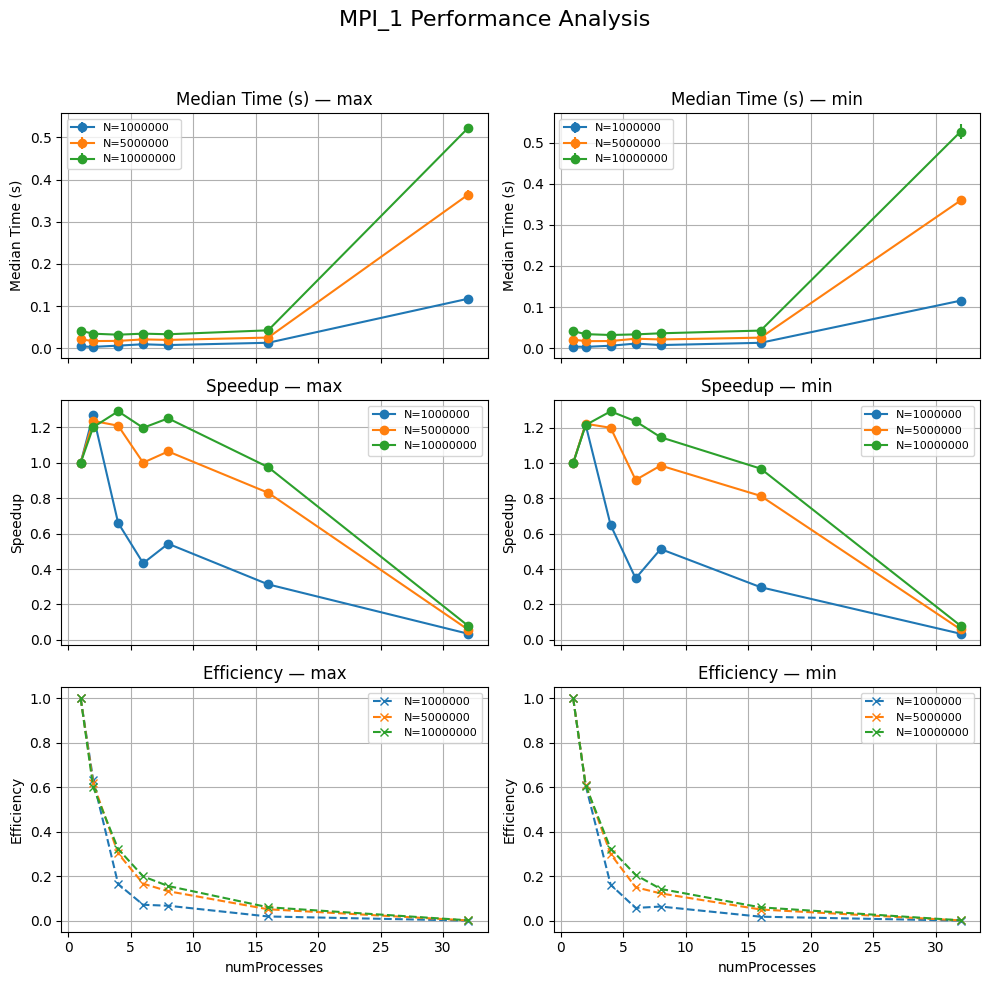

In [15]:
modes = sorted(perfFrame["mode"].unique())
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

fig, axes = plt.subplots(3, len(modes), figsize=(5 * len(modes), 10), sharex=True)
if len(modes) == 1:
    axes2d = np.array([[axes[i]] for i in range(3)])
else:
    axes2d = axes

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        for vectorSizeVal in sorted(perfFrame["vectorSize"].unique()):
            subFrame = perfFrame[(perfFrame["mode"]==modeVal) & (perfFrame["vectorSize"]==vectorSizeVal)].sort_values("numProcesses")
            if subFrame.empty:
                continue
            x = subFrame["numProcesses"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={vectorSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={vectorSizeVal}")
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == 2:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)

plt.suptitle("MPI_1 Performance Analysis", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [16]:
for modeVal in perfFrame["mode"].unique():
    pivotTime = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numProcesses", columns="vectorSize", values="median")
    pivotSpeedup = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numProcesses", columns="vectorSize", values="speedup")
    print(f"\n=== mode: {modeVal} — median time (s) ===")
    display(pivotTime)
    print(f"\n=== mode: {modeVal} — speedup ===")
    display(pivotSpeedup)

summaryRows = []
for (modeVal, vectorSizeVal), sub in perfFrame.groupby(["mode","vectorSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestProcs = int(argMax["numProcesses"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numProcesses"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "vectorSize": vectorSizeVal,
        "bestNumProcesses": bestProcs,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Process": medianAtOne
    })
summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["mode","vectorSize"])
display(summaryAnalysisFrame)



=== mode: max — median time (s) ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,0.004029,0.020911,0.041335
2,0.003176,0.016906,0.034411
4,0.006101,0.017283,0.032016
6,0.009313,0.020894,0.034509
8,0.007423,0.019647,0.033033
16,0.012861,0.025167,0.042368
32,0.117327,0.364185,0.522457



=== mode: max — speedup ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,1.000000,1.000000,1.000000
2,1.268577,1.236898,1.201215
4,0.660384,1.209917,1.291073
6,0.432621,1.000814,1.197803
8,0.542772,1.064336,1.251324
16,0.313273,0.830890,0.975618
32,0.034340,0.057419,0.079117



=== mode: min — median time (s) ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,0.003880,0.020857,0.041459
2,0.003188,0.017055,0.034106
4,0.005981,0.017383,0.032057
6,0.011168,0.023055,0.033522
8,0.007560,0.021153,0.036160
16,0.013055,0.025613,0.042796
32,0.115537,0.359100,0.526498



=== mode: min — speedup ===


vectorSize,1000000,5000000,10000000
numProcesses,,,
1,1.000000,1.000000,1.000000
2,1.217064,1.222926,1.215593
4,0.648721,1.199850,1.293290
6,0.347421,0.904663,1.236770
8,0.513228,0.986007,1.146543
16,0.297204,0.814313,0.968759
32,0.033582,0.058081,0.078745


,mode,vectorSize,bestNumProcesses,maxSpeedup,efficiencyAtBest,medianTime1Process
0,max,1000000,2,1.268577,0.634288,0.004029
1,max,5000000,2,1.236898,0.618449,0.020911
2,max,10000000,4,1.291073,0.322768,0.041335
3,min,1000000,2,1.217064,0.608532,0.003880
4,min,5000000,2,1.222926,0.611463,0.020857
5,min,10000000,4,1.293290,0.323323,0.041459
